In [2]:
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [3]:
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to /Users/edo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/edo/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
df = pd.read_csv("../data/clean_technology_reviews.csv", index_col=0)

In [5]:
df.drop("summary", axis=1, inplace=True)

In [6]:
df

,overall,reviewText
0,5.0,Looks even better in person. Be careful to not...
1,5.0,When you don't want to spend a whole lot of ca...
2,3.0,"so the case came on time, i love the design. I..."
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...
4,4.0,"I liked it because it was cute, but the studs ..."
...,...,...
1128429,4.0,Very good cell phone holster. Keeps my phone ...
1128430,1.0,Mediocre case protection. Clip is junk. Broke/...
1128431,3.0,my sons likes it. For the price it isn't too bad
1128432,4.0,Good for viewing. But doesn't have a button or...


In [7]:
pd.DataFrame(np.unique(df['overall'], return_counts=True)).T.set_index(0)

,1
0,
1.0,73720.0
2.0,51444.0
3.0,87877.0
4.0,157761.0
5.0,615363.0


In [8]:
rev_len = list()
for review in df["reviewText"]:
    rev_len.append(len(str(review)))

In [9]:
df["length"] = rev_len

In [10]:
df["length"].describe()

count    986165.000000
mean        209.004143
std         363.109524
min           1.000000
25%          34.000000
50%         108.000000
75%         240.000000
max       33457.000000
Name: length, dtype: float64

In [11]:
shorter = df[df["length"]<=500].copy()


In [12]:
shorter["reviewText"].fillna("", inplace=True)

In [13]:
shorter = shorter.reset_index(drop='index')

In [14]:
shorter["binary"]= np.where(shorter['overall']>3, 1, 0)

In [15]:
shorter.head(10)

,overall,reviewText,length,binary
0,5.0,Looks even better in person. Be careful to not...,271,1
1,5.0,When you don't want to spend a whole lot of ca...,102,1
2,3.0,"so the case came on time, i love the design. I...",257,0
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,92,0
4,4.0,"I liked it because it was cute, but the studs ...",150,1
5,2.0,The product looked exactly like the picture an...,159,0
6,3.0,I FINALLY got my case today. It took forever t...,344,0
7,5.0,It is a very cute case. None of the jewels hav...,327,1
8,1.0,DO NOT BUY! this item is seriously cheap as he...,190,0
9,4.0,I really love this case... you have to keep yo...,188,1


In [16]:

X_1 = shorter["reviewText"].copy()
y_1= shorter["binary"]


X_rem, X_test, y_rem, y_test = train_test_split(X_1, y_1, test_size=0.2, stratify=y_1,random_state=42)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2,stratify=y_rem, random_state=42)

In [18]:
stop_words = stopwords.words('english')

In [19]:
X_train

235627    I got this wallet case long time ago, but i di...
585595                                            Excellent
265767                                                Junk.
73203     Ordered this for an ATT iPhone 4, which uses a...
823493    Belt clip is a joke.  It breaks very, very, ve...
                                ...                        
835959                                           Thank you.
367914    Great case,fit,value, very nice quality, it's ...
508921              excellent sound is very clear i love it
549396    Bought this for my mom to match her rose gold ...
2242      Excellent seller , very fast shipping , Item a...
Name: reviewText, Length: 569884, dtype: object

In [20]:
def my_tokenizer(document):

    # remove punctuation
    for punct in string.punctuation:
        document=document.replace(punct,'')

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # pattern denoting a sequence of at least 2 alphanumeric characters
    pattern=r"(?u)\b\w\w+\b"

        # tokenize - split by matching a pattern
    tokenized_document = re.findall(pattern, document)
    
    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word not in stop_words]


    stemmed_tokens_list = []
    for i in tokenized_document:
        token = PorterStemmer().stem(i)
        stemmed_tokens_list.append(token)
    return stemmed_tokens_list
#     lemmatized_tokens_list = []
#     for i in tokenized_document:
#         token = WordNetLemmatizer().lemmatize(i, 'v')
#         lemmatized_tokens_list.append(token)
#     return lemmatized_tokens_list



In [21]:
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf.fit(X_train)
X_train_transformed = tfidf.transform(X_train)
X_val_transformed = tfidf.transform(X_val)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [22]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

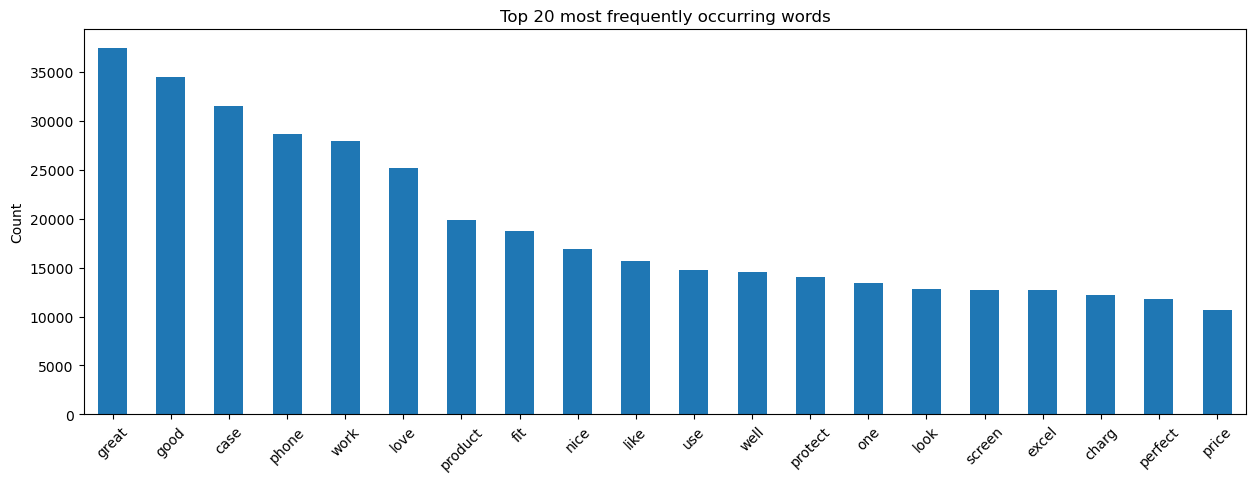

In [23]:
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [25]:
word_counts

,counts
great,37430.797973
good,34420.519445
case,31458.309939
phone,28645.284997
work,27888.941917
...,...
vent,726.851366
happen,724.259493
posit,722.902088
contact,703.979492


In [26]:
feat = tfidf.get_feature_names_out()

In [27]:
english_words = set(nltk.corpus.words.words())

stemmed_english_list = []
for i in english_words:
    token = PorterStemmer().stem(i)
    stemmed_english_list.append(token)


In [28]:
unrecognized_tokens = [token for token in feat if token.lower() not in stemmed_english_list]
num_unrec = len(unrecognized_tokens)
num_unrec/len(feat)

0.048

In [29]:
'explained' in unrecognized_tokens

False

In [32]:
unrecognized_word_counts = word_counts[word_counts.index.isin(unrecognized_tokens)]
len(unrecognized_word_counts)


24

In [31]:
unrecognized_word_counts.sort_values(by = 'counts', ascending=False).head(30)

,counts
iphon,7594.232115
ive,4390.121328
im,4317.398253
samsung,3357.279895
otterbox,2386.744970
usb,2181.052998
okay,1520.041939
isnt,1455.176805
100,1425.554106
s5,1410.428173


In [33]:
"explains" in nltk.corpus.words.words()

False

In [34]:
unrecognized_word_counts.describe()

,counts
count,24.000000
mean,1874.400576
std,1583.374373
min,810.479262
25%,1024.091841
50%,1216.688030
75%,1685.294704
max,7594.232115


In [35]:
unrecognized_word_counts.quantile(0.99)

counts    6857.286634
Name: 0.99, dtype: float64

In [36]:
unrecognized_word_counts.head(10)

,counts
iphon,7594.232115
ive,4390.121328
im,4317.398253
samsung,3357.279895
otterbox,2386.744970
usb,2181.052998
okay,1520.041939
isnt,1455.176805
100,1425.554106
s5,1410.428173


In [37]:
review_vectors = tfidf.transform(shorter["reviewText"].fillna(''))


In [38]:
review_vectors_df = pd.DataFrame(review_vectors.toarray(), columns=tfidf.get_feature_names_out())


In [39]:
output_df = pd.concat([shorter, review_vectors_df], axis=1)

In [40]:
output_df.head(3)

,overall,reviewText,length,binary,10,100,6s,abl,absolut,access,...,wont,work,worri,worth,would,wouldnt,wrong,year,yet,your
0,5.0,Looks even better in person. Be careful to not...,271,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,5.0,When you don't want to spend a whole lot of ca...,102,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,3.0,"so the case came on time, i love the design. I...",257,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206035,0.0


In [41]:
output_df.to_pickle("../data/reviews_vector.pkl")